In [ ]:
!pip install pysimplegui

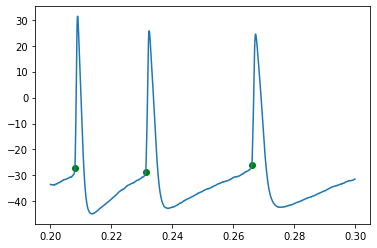

In [1]:
import PySimpleGUI as sg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pyabf
import sys

# VARS CONSTS:
tres = 0
abf = False
while True:
    event, values = sg.Window('Get filename example', [[sg.Text('Filename')], [sg.Input(), sg.FileBrowse()], [sg.OK(), sg.Cancel()] ]).read(close=True)
    if event == 'Cancel':
        break
    try:
        abf = pyabf.ABF(values[0])
        break
    except:
        print('Incorrect file format')
        

def FWHM(X,Y):
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = np.sign(half_max - Y[0:-1]) - np.sign(half_max - Y[1:])
    #plot(X[0:len(d)],d) #if you are interested
    #find the left and right most indexes
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return X[right_idx] - X[left_idx] #return the difference (full width)


def explore_data(x, y, x_spike, y_spike, sweep, channel):
    #Find all spikes values and locations
    global_spike_index = len(y[:int(np.where(x == x_spike[0])[0])])
    spikes = dict()
    for i in range(len(x_spike)-1):
        spike_interval = y[int(np.where(x == x_spike[i])[0]):int(np.where(x == x_spike[i+1])[0])]
        spike = spike_interval.max()
        spike_loc = spike_interval.argmax()
        spikes[global_spike_index+spike_loc] = spike
        global_spike_index += len(spike_interval)
    spike_interval = y[int(np.where(x == x_spike[-1])[0]):]
    spike = spike_interval.max()
    spike_loc = spike_interval.argmax()
    spikes[global_spike_index+spike_loc] = spike
    
    #Find frequencies
    keys_sorted = sorted(list(spikes.keys()))
    freq_firsts = round(1/(x[keys_sorted[1]]-x[keys_sorted[0]]), 2)
    freq_lasts = round(1/(x[keys_sorted[-1]]-x[keys_sorted[-2]]), 2)
    freqs = 0
    for i, key in enumerate(keys_sorted[1:]): #Here we starts from the second element, because we don't need the first spike
        freqs += round(1/(x[keys_sorted[i+1]]-x[keys_sorted[i]]), 2)
    freq_avrg = round(freqs/(len(keys_sorted)-1), 2)
    #print(freq_firsts, freq_lasts, freq_avrg)
    
    first_to_second = round(spikes[keys_sorted[1]]/spikes[keys_sorted[0]], 2)
    #print(first_to_second)
    
    
    #Find FWHW
    spike_interval_x = x[int(np.where(x == x_spike[0])[0]):int(np.where(x == x_spike[1])[0])]
    spike_interval_y = y[int(np.where(x == x_spike[0])[0]):int(np.where(x == x_spike[1])[0])]
    spike_interval_y = [el+abs(spike_interval_y[0]) for el in spike_interval_y] #Here we make it to increase the baseline from -60 to 0
    fwhm = FWHM(spike_interval_x, spike_interval_y)[0]
    
    #Printing result
    print()
    print('Sweep: ', sweep, 'Channel: ', channel)
    print('Spikes values: ', spikes.items())
    print('Spikes baseline values: ', list(y_spike))
    print('Frequency between first two spikes (1/s): ', freq_firsts)
    print('Frequency between last two spikes (1/s): ', freq_lasts)
    print('Average frequency between spikes (1/s): ', freq_avrg)
    print('Relation between first and second spikes (a.u.): ', first_to_second)
    print('FWHW of the first spike (s): ', fwhm)
    print()
    
    
    
    
    
    
    
def get_dataXY(abf, channel, sweep, tres, xmin, xmax, include_first_point, spikes_width):
    try:
        abf.setSweep(sweep, channel = channel)
    except:
        sg.popup_error('Incorrect sweep or channel number')  # Shows red error button
        return
    x = abf.sweepX[np.where(abf.sweepX>xmin)]
    y = abf.sweepY[np.where(abf.sweepX>xmin)]
    x = x[np.where(x<xmax)]
    y = y[np.where(x<xmax)]
    yprime = np.gradient(y, 0.001) # Calculation of the derivative. 
    indx = []
    for i, el in enumerate(yprime):
        if el>tres:
            indx.append(i)
    try:
        indx_filtered = [indx[0]]
    except:
        sg.popup_error('Found no values greater than threshold')  # Shows red error button
    for i in range(len(indx)):
        if indx[i] - indx[i-1] > spikes_width: #Here we assume that spikes are located on a distance more than spikes_width points by x axis
            indx_filtered.append(indx[i])
    if not include_first_point:
        indx_filtered = indx_filtered[1:]
    return x, y, x[indx_filtered], y[indx_filtered]

# New figure and plot variables so we can manipulate them

_VARS = {'window': False,
         'fig_agg': False,
         'pltFig': False}


# Helper Functions


def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg


# \\  -------- PYSIMPLEGUI -------- //
if abf:
    AppFont = 'Any 16'
    sg.theme('DarkTeal12')

    layout = [[sg.Canvas(key='figCanvas')],
              [sg.Text('Enter x axis min'), sg.InputText(0)],
              [sg.Text('Enter x axis max'), sg.InputText(3)],
              [sg.Text('Enter derivative threshold'), sg.InputText(1000)],
              [sg.Text('Enter spikes width threshold'), sg.InputText(100)],
              [sg.Text('Enter sweep number: '), sg.InputText(0)],
              [sg.Text('Enter channel number: '), sg.InputText(0)],
              [sg.Checkbox('Include first point?', default=True)],
              [sg.Button('Explore data', font=AppFont)],
              [sg.Button('Update', font=AppFont), sg.Button('Exit', font=AppFont)]]
    _VARS['window'] = sg.Window('Such Window',
                                layout,
                                finalize=True,
                                resizable=True,
                                location=(100, 100),
                                element_justification="right")

# \\  -------- PYSIMPLEGUI -------- //


# \\  -------- PYPLOT -------- //




def drawChart(abf, channel, sweep, tres):
    _VARS['pltFig'] = plt.figure()
    x, y, x_spike, y_spike = get_dataXY(abf, channel, sweep, tres, 0, 3, True, 100)
    plt.plot(x, y)
    plt.scatter(x_spike, y_spike, c='g')
    plt.xlabel('Time (s)')
    plt.ylabel('Membrane potential (mV)')
    _VARS['fig_agg'] = draw_figure(
        _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])




def updateChart(abf, channel, sweep, tres, xmin, xmax, include_first_point, event, spikes_width):
    _VARS['fig_agg'].get_tk_widget().forget()
    try:
        x, y, x_spike, y_spike = get_dataXY(abf, channel, sweep, tres, xmin, xmax, include_first_point, spikes_width)
    except:
        sg.popup_error('Something went wrong while updating the plot')  # Shows red error button
    # plt.cla()
    if event == 'Update':
        try:
            plt.clf()
            plt.plot(x, y)
            plt.scatter(x_spike, y_spike, c='g')
            _VARS['fig_agg'] = draw_figure(
                _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])
        except:
            pass
    elif event == 'Explore data':
        plt.clf()
        plt.plot(x, y)
        plt.scatter(x_spike, y_spike, c='g')
        _VARS['fig_agg'] = draw_figure(
            _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])
        try:
            explore_data(x, y, x_spike, y_spike, sweep, channel)
        except:
            sg.popup_error('Something went wrong while exploring the data')  # Shows red error button
            

# \\  -------- PYPLOT -------- //
if abf:
    drawChart(abf, 0, 0, tres)

    # MAIN LOOP
    while True:
        event, values = _VARS['window'].read()
        xmin = float(values[0])
        xmax = float(values[1])
        tres = int(values[2])
        spikes_width = int(values[3])
        sweep = int(values[4])
        channel = int(values[5])
        include_first_point = bool(values[6])
        if event == sg.WIN_CLOSED or event == 'Exit':
            break
        # New Button (check the layout) and event catcher for the plot update
        updateChart(abf, channel, sweep, tres, xmin, xmax, include_first_point, event, spikes_width)
    _VARS['window'].close()